In [1]:
from __future__ import print_function
import argparse
import os
import shutil
import time
import random
import pickle
import torch
import pdb
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from utils import Bar, Logger, AverageMeter, accuracy, mkdir_p, savefig
import numpy as np
import copy
import math
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.autograd import gradcheck
from torch.nn import init
import sys
import random
import collections
import warnings
warnings.filterwarnings("ignore")

In [2]:
class args:
    checkpoint = "results/cifar100/meta_mnist_T5_47"  # checkpoint保存的地方
    savepoint = "models/" + "/".join(checkpoint.split("/")[1:])  # savepoint保存的地方
    data_path = "../Datasets/MNIST/"  # 数据集保存的位置
    num_class = 10 # 类的数量
    class_per_task = 2 # 每个task有多少个class
    num_task = 5 # task的数量
    test_samples_per_class = 1000 # 测试的时候每个class的sample数量
    dataset = "mnist" # 数据集
    optimizer = 'sgd' # 优化器 SGD
    epochs = 20 # 训练的epoch数量
    lr = 0.1 # 学习率
    train_batch = 256 # 训练的batch
    test_batch = 256 # 测试的batch
    workers = 16 # ？？
    sess = 0 # SESS
    schedule = [5,10,15]
    gamma = 0.5
    random_classes = False
    validation = 0
    memory = 2000
    mu = 1
    beta = 0.5
    r = 1

In [3]:
state = {key:value for key, value in args.__dict__.items() if not key.startswith('__') and not callable(key)}
print(state)

{'checkpoint': 'results/cifar100/meta_mnist_T5_47', 'savepoint': 'models/cifar100/meta_mnist_T5_47', 'data_path': '../Datasets/MNIST/', 'num_class': 10, 'class_per_task': 2, 'num_task': 5, 'test_samples_per_class': 1000, 'dataset': 'mnist', 'optimizer': 'sgd', 'epochs': 20, 'lr': 0.1, 'train_batch': 256, 'test_batch': 256, 'workers': 16, 'sess': 0, 'schedule': [5, 10, 15], 'gamma': 0.5, 'random_classes': False, 'validation': 0, 'memory': 2000, 'mu': 1, 'beta': 0.5, 'r': 1}


In [4]:
use_cuda = torch.cuda.is_available()
seed = random.randint(1, 10000)
seed = 2481 
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed_all(seed)

In [5]:
class RPS_net_mlp(nn.Module):

        def __init__(self):
            super(RPS_net_mlp, self).__init__()
            self.init()

        def init(self):
            """Initialize all parameters"""
            self.mlp1 = nn.Linear(784, 400)
            self.mlp2 = nn.Linear(400, 400)
            self.relu = nn.ReLU()
            self.fc = nn.Linear(400, 10, bias=False)
            self.sigmoid = nn.Sigmoid()
            
            self.cuda()

        def forward(self, x):

            x = x.view(-1, 784)
            y = self.mlp1(x)
            y = F.relu(y)
            
            y = self.mlp2(y)
            y = F.relu(y)

            x1 = self.fc(y)
            x2 = self.fc(y)
            
#             x1 = self.sigmoid(x1)
#             x2 = self.sigmoid(x2)
            return x2, x1

In [6]:
class BasicNet1(nn.Module):

    def __init__(
        self, args, use_bias=False, init="kaiming", use_multi_fc=False, device=None
    ):
        super(BasicNet1, self).__init__()

        self.use_bias = use_bias
        self.init = init
        self.use_multi_fc = use_multi_fc
        self.args = args

        if(self.args.dataset=="mnist"):
            self.convnet = RPS_net_mlp()
    
        self.classifier = None

        self.n_classes = 0
        self.device = device
        self.cuda()
        
    def forward(self, x):
        x1, x2 = self.convnet(x)
        return x1, x2

    @property
    def features_dim(self):
        return self.convnet.out_dim

    def extract(self, x):
        return self.convnet(x)

    def freeze(self):
        for param in self.parameters():
            param.requires_grad = False
        self.eval()

        return self

    def copy(self):
        return copy.deepcopy(self)
    
    def add_classes(self, n_classes):
        if self.use_multi_fc:
            self._add_classes_multi_fc(n_classes)
        else:
            self._add_classes_single_fc(n_classes)

        self.n_classes += n_classes
        
    def _add_classes_multi_fc(self, n_classes):
        if self.classifier is None:
            self.classifier = []

        new_classifier = self._gen_classifier(n_classes)
        name = "_clf_{}".format(len(self.classifier))
        self.__setattr__(name, new_classifier)
        self.classifier.append(name)

    def _add_classes_single_fc(self, n_classes):
        if self.classifier is not None:
            weight = copy.deepcopy(self.classifier.weight.data)
            if self.use_bias:
                bias = copy.deepcopy(self.classifier.bias.data)

        classifier = self._gen_classifier(self.n_classes + n_classes)

        if self.classifier is not None:
            classifier.weight.data[:self.n_classes] = weight
            if self.use_bias:
                classifier.bias.data[:self.n_classes] = bias

        del self.classifier
        self.classifier = classifier

    def _gen_classifier(self, n_classes):
#         torch.manual_seed(self.seed)
        classifier = nn.Linear(self.convnet.out_dim, n_classes, bias=self.use_bias).cuda()
        if self.init == "kaiming":
            nn.init.kaiming_normal_(classifier.weight, nonlinearity="linear")
        if self.use_bias:
            nn.init.constant_(classifier.bias, 0.)

        return classifier

In [7]:
model = BasicNet1(args, 0).cuda() 

In [8]:
print('  Total params: %.2fM ' % (sum(p.numel() for p in model.parameters())/1000000.0))

  Total params: 0.48M 


In [9]:
if not os.path.isdir(args.checkpoint):
    mkdir_p(args.checkpoint)
if not os.path.isdir(args.savepoint):
    mkdir_p(args.savepoint)
np.save(args.checkpoint + "/seed.npy", seed)

In [10]:
import random
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Sampler
from torchvision import datasets, transforms
# from imagenet import ImageNet
from idatasets.CUB200 import Cub2011
from idatasets.omniglot import Omniglot
from idatasets.celeb_1m import MS1M
import collections
from utils.cutout import Cutout

class SubsetRandomSampler(Sampler):
    r"""Samples elements randomly from a given list of indices, without replacement.

    Arguments:
        indices (sequence): a sequence of indices
    """

    def __init__(self, indices, shuffle):
        self.indices = indices
        self.shuffle = shuffle

    def __iter__(self):
        if(self.shuffle):
            return (self.indices[i] for i in torch.randperm(len(self.indices)))
        else:
            return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    

class IncrementalDataset:

    def __init__(
        self,
        dataset_name,
        args,
        random_order=False,
        shuffle=True,
        workers=10,
        batch_size=128,
        seed=1,
        increment=10,
        validation_split=0.
    ):
        self.dataset_name = dataset_name.lower().strip()
        datasets = _get_datasets(dataset_name)
        self.train_transforms = datasets[0].train_transforms 
        self.common_transforms = datasets[0].common_transforms
        try:
            self.meta_transforms = datasets[0].meta_transforms
        except:
            self.meta_transforms = datasets[0].train_transforms
        self.args = args
        
        self._setup_data(
            datasets,
            args.data_path,
            random_order=random_order,
            seed=seed,
            increment=increment,
            validation_split=validation_split
        )
        

        self._current_task = 0

        self._batch_size = batch_size
        self._workers = workers
        self._shuffle = shuffle
        self.sample_per_task_testing = {}
    @property
    def n_tasks(self):
        return len(self.increments)
    
    def get_same_index(self, target, label, mode="train", memory=None):
        label_indices = []
        label_targets = []

        for i in range(len(target)):
            if int(target[i]) in label:
                label_indices.append(i)
                label_targets.append(target[i])
        for_memory = (label_indices.copy(),label_targets.copy())
        
#         if(self.args.overflow and not(mode=="test")):
#             memory_indices, memory_targets = memory
#             return memory_indices, memory
            
        if memory is not None:
            memory_indices, memory_targets = memory
            memory_indices2 = np.tile(memory_indices, (self.args.mu,))
            all_indices = np.concatenate([memory_indices2,label_indices])
        else:
            all_indices = label_indices
            
        return all_indices, for_memory
    
    def get_same_index_test_chunk(self, target, label, mode="test", memory=None):
        label_indices = []
        label_targets = []
        
        np_target = np.array(target, dtype="uint32")
        np_indices = np.array(list(range(len(target))), dtype="uint32")

        for t in range(len(label)//self.args.class_per_task):
            task_idx = []
            for class_id in label[t*self.args.class_per_task: (t+1)*self.args.class_per_task]:
                idx = np.where(np_target==class_id)[0]
                task_idx.extend(list(idx.ravel()))
            task_idx = np.array(task_idx, dtype="uint32")
            task_idx.ravel()
            random.shuffle(task_idx)

            label_indices.extend(list(np_indices[task_idx]))
            label_targets.extend(list(np_target[task_idx]))
            if(t not in self.sample_per_task_testing.keys()):
                self.sample_per_task_testing[t] = len(task_idx)
        label_indices = np.array(label_indices, dtype="uint32")
        label_indices.ravel()
        return list(label_indices), label_targets
    

    def new_task(self, memory=None):
        
        print(self._current_task)
        print(self.increments)
        min_class = sum(self.increments[:self._current_task])
        max_class = sum(self.increments[:self._current_task + 1])
#         if(self.args.overflow):
#             min_class = 0
#             max_class = sum(self.increments)
        
        train_indices, for_memory = self.get_same_index(self.train_dataset.targets, list(range(min_class, max_class)), mode="train", memory=memory)
        test_indices, _ = self.get_same_index_test_chunk(self.test_dataset.targets, list(range(max_class)), mode="test")

        self.train_data_loader = torch.utils.data.DataLoader(self.train_dataset, batch_size=self._batch_size,shuffle=False,num_workers=16, sampler=SubsetRandomSampler(train_indices, True))
        self.test_data_loader = torch.utils.data.DataLoader(self.test_dataset, batch_size=self.args.test_batch,shuffle=False,num_workers=16, sampler=SubsetRandomSampler(test_indices, False))

        
        task_info = {
            "min_class": min_class,
            "max_class": max_class,
            "task": self._current_task,
            "max_task": len(self.increments),
            "n_train_data": len(train_indices),
            "n_test_data": len(test_indices)
        }

        self._current_task += 1

        return task_info, self.train_data_loader, self.test_data_loader, self.test_data_loader, for_memory
    
     
        
    # for verification   
    def get_galary(self, task, batch_size=10):
        indexes = []
        dict_ind = {}
        seen_classes = []
        for i, t in enumerate(self.train_dataset.targets):
            if not(t in seen_classes) and (t< (task+1)*self.args.class_per_task and (t>= (task)*self.args.class_per_task)):
                seen_classes.append(t)
                dict_ind[t] = i
                
        od = collections.OrderedDict(sorted(dict_ind.items()))
        for k, v in od.items(): 
            indexes.append(v)
            
        data_loader = torch.utils.data.DataLoader(self.train_dataset, batch_size=batch_size, shuffle=False, num_workers=4, sampler=SubsetRandomSampler(indexes, False))
    
        return data_loader
    
    
    def get_custom_loader_idx(self, indexes, mode="train", batch_size=10, shuffle=True):
     
        if(mode=="train"):
            data_loader = torch.utils.data.DataLoader(self.train_dataset, batch_size=batch_size, shuffle=False, num_workers=4, sampler=SubsetRandomSampler(indexes, True))
        else: 
            data_loader = torch.utils.data.DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, sampler=SubsetRandomSampler(indexes, False))
    
        return data_loader
    
    
    def get_custom_loader_class(self, class_id, mode="train", batch_size=10, shuffle=False):
        
        if(mode=="train"):
            train_indices, for_memory = self.get_same_index(self.train_dataset.targets, class_id, mode="train", memory=None)
            data_loader = torch.utils.data.DataLoader(self.train_dataset, batch_size=batch_size, shuffle=False, num_workers=4, sampler=SubsetRandomSampler(train_indices, True))
        else: 
            test_indices, _ = self.get_same_index(self.test_dataset.targets, class_id, mode="test")
            data_loader = torch.utils.data.DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, sampler=SubsetRandomSampler(test_indices, False))
            
        return data_loader

    def _setup_data(self, datasets, path, random_order=False, seed=1, increment=10, validation_split=0.):
        self.increments = []
        self.class_order = []
        
        trsf_train = transforms.Compose(self.train_transforms)
        try:
            trsf_mata = transforms.Compose(self.meta_transforms)
        except:
            trsf_mata = transforms.Compose(self.train_transforms)
            
        trsf_test = transforms.Compose(self.common_transforms)
        
        current_class_idx = 0  # When using multiple datasets
        for dataset in datasets:
            if(self.dataset_name=="imagenet"):
                train_dataset = dataset.base_dataset(root=path, split='train', download=False, transform=trsf_train)
                test_dataset = dataset.base_dataset(root=path, split='val', download=False, transform=trsf_test)
                
            elif(self.dataset_name=="cub200" or self.dataset_name=="cifar100" or self.dataset_name=="mnist"  or self.dataset_name=="caltech101"  or self.dataset_name=="omniglot"  or self.dataset_name=="celeb"):
                train_dataset = dataset.base_dataset(root=path, train=True, download=True, transform=trsf_train)
                test_dataset = dataset.base_dataset(root=path, train=False, download=True, transform=trsf_test)

            elif(self.dataset_name=="svhn"):
                train_dataset = dataset.base_dataset(root=path, split='train', download=True, transform=trsf_train)
                test_dataset = dataset.base_dataset(root=path, split='test', download=True, transform=trsf_test)
                train_dataset.targets = train_dataset.labels
                test_dataset.targets = test_dataset.labels
                
                
            order = [i for i in range(self.args.num_class)]
            if random_order:
                random.seed(seed)  
                random.shuffle(order)
            elif dataset.class_order is not None:
                order = dataset.class_order
                
            for i,t in enumerate(train_dataset.targets):
                train_dataset.targets[i] = order[t]
            for i,t in enumerate(test_dataset.targets):
                test_dataset.targets[i] = order[t]
            self.class_order.append(order)

            self.increments = [increment for _ in range(len(order) // increment)]

        self.train_dataset = train_dataset
        self.test_dataset = test_dataset

    @staticmethod
    def _map_new_class_index(y, order):
        """Transforms targets for new class order."""
        return np.array(list(map(lambda x: order.index(x), y)))
    
    
    def get_memory(self, memory, for_memory, seed=1):
        random.seed(seed)
        memory_per_task = self.args.memory // ((self.args.sess+1)*self.args.class_per_task)
        self._data_memory, self._targets_memory = np.array([]), np.array([])
        mu = 1
        
        #update old memory
        if(memory is not None):
            data_memory, targets_memory = memory
            data_memory = np.array(data_memory, dtype="int32")
            targets_memory = np.array(targets_memory, dtype="int32")
            for class_idx in range(self.args.class_per_task*(self.args.sess)):
                idx = np.where(targets_memory==class_idx)[0][:memory_per_task]
                self._data_memory = np.concatenate([self._data_memory, np.tile(data_memory[idx], (mu,))   ])
                self._targets_memory = np.concatenate([self._targets_memory, np.tile(targets_memory[idx], (mu,))    ])
                
                
        #add new classes to the memory
        new_indices, new_targets = for_memory

        new_indices = np.array(new_indices, dtype="int32")
        new_targets = np.array(new_targets, dtype="int32")
        for class_idx in range(self.args.class_per_task*(self.args.sess),self.args.class_per_task*(1+self.args.sess)):
            idx = np.where(new_targets==class_idx)[0][:memory_per_task]
            self._data_memory = np.concatenate([self._data_memory, np.tile(new_indices[idx],(mu,))   ])
            self._targets_memory = np.concatenate([self._targets_memory, np.tile(new_targets[idx],(mu,))    ])
            
        print(len(self._data_memory))
        return list(self._data_memory.astype("int32")), list(self._targets_memory.astype("int32"))
    
def _get_datasets(dataset_names):
    return [_get_dataset(dataset_name) for dataset_name in dataset_names.split("-")]


def _get_dataset(dataset_name):
    dataset_name = dataset_name.lower().strip()

    if dataset_name == "cifar10":
        return iCIFAR10
    elif dataset_name == "cifar100":
        return iCIFAR100
    elif dataset_name == "imagenet":
        return iIMAGENET
    elif dataset_name == "cub200":
        return iCUB200
    elif dataset_name == "mnist":
        return iMNIST
    elif dataset_name == "caltech101":
        return iCALTECH101
    elif dataset_name == "celeb":
        return iCELEB
    elif dataset_name == "svhn":
        return iSVHN
    elif dataset_name == "omniglot":
        return iOMNIGLOT
    
    else:
        raise NotImplementedError("Unknown dataset {}.".format(dataset_name))


class DataHandler:
    base_dataset = None
    train_transforms = []
    mata_transforms = [transforms.ToTensor()]
    common_transforms = [transforms.ToTensor()]
    class_order = None


class iCIFAR10(DataHandler):
    base_dataset = datasets.cifar.CIFAR10
    train_transforms = [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=63 / 255),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]
    common_transforms = [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]


class iCIFAR100(DataHandler):
    base_dataset = datasets.cifar.CIFAR100
    train_transforms = [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ]
    
    common_transforms = [
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ]
    

    
class iCALTECH101(DataHandler):
    base_dataset = datasets.Caltech101
    train_transforms = [
        transforms.Resize(136),
        transforms.RandomCrop(128, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
#         transforms.ColorJitter(brightness=63 / 255),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ]
    
    common_transforms = [
        transforms.Resize(130),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ]

class iCELEB(DataHandler):
    
    base_dataset = MS1M

    train_transforms = [
        transforms.RandomCrop(112, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ]
    
    common_transforms = [
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ]

class iIMAGENET(DataHandler):
    base_dataset = datasets.ImageNet
    train_transforms = [
        transforms.Resize(120),
        transforms.RandomResizedCrop(112),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
#         transforms.ColorJitter(brightness=63 / 255),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
    common_transforms = [
        transforms.Resize(115),
        transforms.CenterCrop(112),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]


class iCUB200(DataHandler):
    base_dataset = Cub2011
    train_transforms = [
        transforms.Resize(230),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=63 / 255),
        transforms.ToTensor(),
        
    ]
    common_transforms = [
        transforms.Resize(230),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]

    
class iMNIST(DataHandler):
    base_dataset = datasets.MNIST
    train_transforms = [ transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)) ]
    common_transforms = [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]

class iSVHN(DataHandler):
    base_dataset = datasets.SVHN
    train_transforms = [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
    common_transforms = [
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
    
class iOMNIGLOT(DataHandler):
    base_dataset = datasets.Omniglot
    train_transforms = [ transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)) ]
    common_transforms = [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]

In [11]:
inc_dataset = IncrementalDataset(
                        dataset_name=args.dataset,
                        args = args,
                        random_order=args.random_classes,
                        shuffle=True,
                        seed=1,
                        batch_size=args.train_batch,
                        workers=args.workers,
                        validation_split=args.validation,
                        increment=args.class_per_task,
                    )

In [17]:
start_sess = 4
memory = None

In [13]:
import os
import torch
from utils import Bar, Logger, AverageMeter, accuracy, mkdir_p, savefig
import torch.optim as optim
import time
import pickle
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pdb
import copy


class ResNet_features(nn.Module):
    def __init__(self, original_model):
        super(ResNet_features, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        
    def forward(self, x):
        x = self.features(x)
        return x
    
class Learner():
    def __init__(self,model,args,trainloader,testloader, use_cuda):
        self.model=model
        self.best_model=model
        self.args=args
        self.title='incremental-learning' + self.args.checkpoint.split("/")[-1]
        self.trainloader=trainloader 
        self.use_cuda=use_cuda
        self.state= {key:value for key, value in self.args.__dict__.items() if not key.startswith('__') and not callable(key)} 
        self.best_acc = 0 
        self.testloader=testloader
        self.test_loss=0.0
        self.test_acc=0.0
        self.train_loss, self.train_acc=0.0,0.0       
        
        meta_parameters = []
        normal_parameters = []
        for n,p in self.model.named_parameters():
            meta_parameters.append(p)
            p.requires_grad = True
            if("fc" in n):
                normal_parameters.append(p)
      
        if(self.args.optimizer=="radam"):
            self.optimizer = RAdam(meta_parameters, lr=self.args.lr, betas=(0.9, 0.999), weight_decay=0)
        elif(self.args.optimizer=="adam"):
            self.optimizer = optim.Adam(self.model.parameters(), lr=self.args.lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0, amsgrad=False)
        elif(self.args.optimizer=="sgd"):
            self.optimizer = optim.SGD(meta_parameters, lr=self.args.lr, momentum=0.9, weight_decay=0.001)
 

    def learn(self):
        logger = Logger(os.path.join(self.args.checkpoint, 'session_'+str(self.args.sess)+'_log.txt'), title=self.title)
        logger.set_names(['Learning Rate', 'Train Loss', 'Valid Loss', 'Train Acc.', 'Valid Acc.', 'Best Acc'])
            
        for epoch in range(0, self.args.epochs):
            self.adjust_learning_rate(epoch)
            print('\nEpoch: [%d | %d] LR: %f Sess: %d' % (epoch + 1, self.args.epochs, self.state['lr'],self.args.sess))

            self.train(self.model, epoch)
#             if(epoch> self.args.epochs-5):
            self.test(self.model)
        
            # append logger file
            logger.append([self.state['lr'], self.train_loss, self.test_loss, self.train_acc, self.test_acc, self.best_acc])

            # save model
            is_best = self.test_acc > self.best_acc
            if(is_best and epoch>self.args.epochs-10):
                self.best_model = copy.deepcopy(self.model)

            self.best_acc = max(self.test_acc, self.best_acc)
            if(epoch==self.args.epochs-1):
                self.save_checkpoint(self.best_model.state_dict(), True, checkpoint=self.args.savepoint, filename='session_'+str(self.args.sess)+'_model_best.pth.tar')
        self.model = copy.deepcopy(self.best_model)
        
        logger.close()
        logger.plot()
        savefig(os.path.join(self.args.checkpoint, 'log.eps'))

        print('Best acc:')
        print(self.best_acc)
    
    def train(self, model, epoch):
        model.train()

        batch_time = AverageMeter()
        data_time = AverageMeter()
        losses = AverageMeter()
        top1 = AverageMeter()
        top5 = AverageMeter()
        end = time.time()
        
        bi = self.args.class_per_task*(1+self.args.sess)
        bar = Bar('Processing', max=len(self.trainloader))
        
        for batch_idx, (inputs, targets) in enumerate(self.trainloader):
            # measure data loading time
            data_time.update(time.time() - end)
            sessions = []
             
            targets_one_hot = torch.FloatTensor(inputs.shape[0], bi)
            targets_one_hot.zero_()
            targets_one_hot.scatter_(1, targets[:,None], 1)
    
            if self.use_cuda:
                inputs, targets_one_hot, targets = inputs.cuda(), targets_one_hot.cuda(),targets.cuda()
            inputs, targets_one_hot, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets_one_hot),torch.autograd.Variable(targets)

            reptile_grads = {}            
            np_targets = targets.detach().cpu().numpy()
            num_updates = 0
            
            outputs2, _ = model(inputs)
            
            model_base = copy.deepcopy(model)
            for task_idx in range(1+self.args.sess):
                idx = np.where((np_targets>= task_idx*self.args.class_per_task) & (np_targets < (task_idx+1)*self.args.class_per_task))[0]
                ai = self.args.class_per_task*task_idx
                bi = self.args.class_per_task*(task_idx+1)
                
                ii = 0
                if(len(idx)>0):
                    sessions.append([task_idx, ii])
                    ii += 1
                    for i,(p,q) in enumerate(zip(model.parameters(), model_base.parameters())):
                        p=copy.deepcopy(q)
                        
                    class_inputs = inputs[idx]
                    class_targets_one_hot= targets_one_hot[idx]
                    class_targets = targets[idx]
                    
                    if(self.args.sess==task_idx and self.args.sess==4 and self.args.dataset=="svhn"):
                        self.args.r = 4
                    else:
                        self.args.r = 1
                        
                    for kr in range(self.args.r):
                        _, class_outputs = model(class_inputs)

                        class_tar_ce=class_targets_one_hot.clone()
                        class_pre_ce=class_outputs.clone()
                        loss = F.binary_cross_entropy_with_logits(class_pre_ce[:, ai:bi], class_tar_ce[:, ai:bi]) 
                        self.optimizer.zero_grad()
                        loss.backward()
                        self.optimizer.step()

                    for i,p in enumerate(model.parameters()):
                        if(num_updates==0):
                            reptile_grads[i] = [p.data]
                        else:
                            reptile_grads[i].append(p.data)
                    num_updates += 1
            
            for i,(p,q) in enumerate(zip(model.parameters(), model_base.parameters())):
                alpha = np.exp(-self.args.beta*((1.0*self.args.sess)/self.args.num_task))
#                 alpha = np.exp(-0.05*self.args.sess)
                ll = torch.stack(reptile_grads[i])
#                 if(p.data.size()[0]==10 and p.data.size()[1]==256):
# #                     print(sessions)
#                     for ik in sessions:
# #                         print(ik)
#                         p.data[2*ik[0]:2*(ik[0]+1),:] = ll[ik[1]][2*ik[0]:2*(ik[0]+1),:]*(alpha) + (1-alpha)* q.data[2*ik[0]:2*(ik[0]+1),:]
#                 else:
                p.data = torch.mean(ll,0)*(alpha) + (1-alpha)* q.data  
                    
                
            
        
            # measure accuracy and record loss
            prec1, prec5 = accuracy(output=outputs2.data[:,0:bi], target=targets.cuda().data, topk=(1, 1))
            losses.update(loss.item(), inputs.size(0))
            top1.update(prec1.item(), inputs.size(0))
            top5.update(prec5.item(), inputs.size(0))
            
            
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            # plot progress
            bar.suffix  = '({batch}/{size}) | Total: {total:} | Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f} '.format(
                        batch=batch_idx + 1,
                        size=len(self.trainloader),
                        total=bar.elapsed_td,
                        loss=losses.avg,
                        top1=top1.avg,
                        top5=top5.avg
                        )
            bar.next()
        bar.finish()

        self.train_loss,self.train_acc=losses.avg, top1.avg

    def test(self, model):

        batch_time = AverageMeter()
        data_time = AverageMeter()
        losses = AverageMeter()
        top1 = AverageMeter()
        top5 = AverageMeter()
        class_acc = {}
        
        
        # switch to evaluate mode
        model.eval()
        ai = 0
        bi = self.args.class_per_task*(self.args.sess+1)
        
        end = time.time()
        bar = Bar('Processing', max=len(self.testloader))
        for batch_idx, (inputs, targets) in enumerate(self.testloader):
            # measure data loading time
            data_time.update(time.time() - end)
#             print(targets)
            targets_one_hot = torch.FloatTensor(inputs.shape[0], self.args.num_class)
            targets_one_hot.zero_()
            targets_one_hot.scatter_(1, targets[:,None], 1)
            target_set = np.unique(targets)
            
            if self.use_cuda:
                inputs, targets_one_hot,targets = inputs.cuda(), targets_one_hot.cuda(),targets.cuda()
            inputs, targets_one_hot, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets_one_hot) ,torch.autograd.Variable(targets)

            outputs2, outputs = model(inputs)
            loss = F.binary_cross_entropy_with_logits(outputs[ai:bi], targets_one_hot[ai:bi])
                    
            prec1, prec5 = accuracy(outputs2.data[:,0:self.args.class_per_task*(1+self.args.sess)], targets.cuda().data, topk=(1, 1))


            losses.update(loss.item(), inputs.size(0))
            top1.update(prec1.item(), inputs.size(0))
            top5.update(prec5.item(), inputs.size(0))
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
            
            pred = torch.argmax(outputs2[:,0:self.args.class_per_task*(1+self.args.sess)], 1, keepdim=False)
            pred = pred.view(1,-1)
            correct = pred.eq(targets.view(1, -1).expand_as(pred)).view(-1) 
            correct_k = float(torch.sum(correct).detach().cpu().numpy())

            for i,p in enumerate(pred.view(-1)):
                key = int(p.detach().cpu().numpy())
                if(correct[i]==1):
                    if(key in class_acc.keys()):
                        class_acc[key] += 1
                    else:
                        class_acc[key] = 1
                        
                        
            # plot progress
            bar.suffix  = '({batch}/{size})  Total: {total:} | Loss: {loss:.4f} | top1: {top1: .4f} | top1_task: {top5: .4f}'.format(
                        batch=batch_idx + 1,
                        size=len(self.testloader),
                        total=bar.elapsed_td,
                        loss=losses.avg,
                        top1=top1.avg,
                        top5=top5.avg
                        )
            bar.next()
        bar.finish()
        self.test_loss= losses.avg;self.test_acc= top1.avg
            
        acc_task = {}
        for i in range(self.args.sess+1):
            acc_task[i] = 0
            for j in range(self.args.class_per_task):
                try:
                    acc_task[i] += class_acc[i*self.args.class_per_task+j]/self.args.sample_per_task_testing[i] * 100
                except:
                    pass
        print("\n".join([str(acc_task[k]).format(".4f") for k in acc_task.keys()]) )    
        print(class_acc)

        
        with open(self.args.savepoint + "/acc_task_test_"+str(self.args.sess)+".pickle", 'wb') as handle:
            pickle.dump(acc_task, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    
    def meta_test(self, model, memory, inc_dataset):

        # switch to evaluate mode
        model.eval()
        
        meta_models = []   
        base_model = copy.deepcopy(model)
        class_acc = {}
        meta_task_test_list = {}
        for task_idx in range(self.args.sess+1):
            
            memory_data, memory_target = memory
            memory_data = np.array(memory_data, dtype="int32")
            memory_target = np.array(memory_target, dtype="int32")
            
            
            mem_idx = np.where((memory_target>= task_idx*self.args.class_per_task) & (memory_target < (task_idx+1)*self.args.class_per_task))[0]
            meta_memory_data = memory_data[mem_idx]
            meta_memory_target = memory_target[mem_idx]
            meta_model = copy.deepcopy(base_model)
            
            meta_loader = inc_dataset.get_custom_loader_idx(meta_memory_data, mode="train", batch_size=64)

            meta_optimizer = optim.Adam(meta_model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0, amsgrad=False)
            
            meta_model.train()
            
            ai = self.args.class_per_task*task_idx
            bi = self.args.class_per_task*(task_idx+1)
            bb = self.args.class_per_task*(self.args.sess+1)
            print("Training meta tasks:\t" , task_idx)
                
            #META training
            if(self.args.sess!=0):
                for ep in range(1):
                    bar = Bar('Processing', max=len(meta_loader))
                    for batch_idx, (inputs, targets) in enumerate(meta_loader):
                        targets_one_hot = torch.FloatTensor(inputs.shape[0], (task_idx+1)*self.args.class_per_task)
                        targets_one_hot.zero_()
                        targets_one_hot.scatter_(1, targets[:,None], 1)
                        target_set = np.unique(targets)

                        if self.use_cuda:
                            inputs, targets_one_hot,targets = inputs.cuda(), targets_one_hot.cuda(),targets.cuda()
                        inputs, targets_one_hot, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets_one_hot) ,torch.autograd.Variable(targets)

                        _, outputs = meta_model(inputs)
                        class_pre_ce=outputs.clone()
                        class_pre_ce = class_pre_ce[:, ai:bi]
                        class_tar_ce=targets_one_hot.clone()

                        loss = F.binary_cross_entropy_with_logits(class_pre_ce, class_tar_ce[:, ai:bi])

                        meta_optimizer.zero_grad()
                        loss.backward()
                        meta_optimizer.step()
                        bar.suffix  = '({batch}/{size})  Total: {total:} | Loss: {loss:.4f}'.format(
                                        batch=batch_idx + 1,
                                        size=len(meta_loader),
                                        total=bar.elapsed_td,
                                        loss=loss)
                        bar.next()
                    bar.finish()

            
            #META testing with given knowledge on task
            meta_model.eval()   
            for cl in range(self.args.class_per_task):
                class_idx = cl + self.args.class_per_task*task_idx
                loader = inc_dataset.get_custom_loader_class([class_idx], mode="test", batch_size=10)

                for batch_idx, (inputs, targets) in enumerate(loader):
                    targets_task = targets-self.args.class_per_task*task_idx

                    if self.use_cuda:
                        inputs, targets_task = inputs.cuda(),targets_task.cuda()
                    inputs, targets_task = torch.autograd.Variable(inputs), torch.autograd.Variable(targets_task)

                    _, outputs = meta_model(inputs)

                    if self.use_cuda:
                        inputs, targets = inputs.cuda(),targets_task.cuda()
                    inputs, targets_task = torch.autograd.Variable(inputs), torch.autograd.Variable(targets_task)

                    pred = torch.argmax(outputs[:,ai:bi], 1, keepdim=False)
                    pred = pred.view(1,-1)
                    correct = pred.eq(targets_task.view(1, -1).expand_as(pred)).view(-1) 

                    correct_k = float(torch.sum(correct).detach().cpu().numpy())

                    for i,p in enumerate(pred.view(-1)):
                        key = int(p.detach().cpu().numpy())
                        key = key + self.args.class_per_task*task_idx
                        if(correct[i]==1):
                            if(key in class_acc.keys()):
                                class_acc[key] += 1
                            else:
                                class_acc[key] = 1
                                

            
#           META testing - no knowledge on task
            meta_model.eval()   
            for batch_idx, (inputs, targets) in enumerate(self.testloader):
                if self.use_cuda:
                    inputs, targets = inputs.cuda(), targets.cuda()
                inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)
                             
                _, outputs = meta_model(inputs)
                outputs_base, _ = self.model(inputs)
                task_ids = outputs

                task_ids = task_ids.detach().cpu()
                outputs = outputs.detach().cpu()
                outputs = outputs.detach().cpu()
                outputs_base = outputs_base.detach().cpu()
                
                bs = inputs.size()[0]
                for i,t in enumerate(list(range(bs))):
                    j = batch_idx*self.args.test_batch + i
                    output_base_max = []
                    for si in range(self.args.sess+1):
                        sj = outputs_base[i][si* self.args.class_per_task:(si+1)* self.args.class_per_task]
                        sq = torch.max(sj)
                        output_base_max.append(sq)
                    
                    task_argmax = np.argsort(outputs[i][ai:bi])[-5:]
                    task_max = outputs[i][ai:bi][task_argmax]
                    
                    if ( j not in meta_task_test_list.keys()):
                        meta_task_test_list[j] = [[task_argmax,task_max, output_base_max,targets[i]]]
                    else:
                        meta_task_test_list[j].append([task_argmax,task_max, output_base_max,targets[i]])
            del meta_model
                                
        acc_task = {}
        for i in range(self.args.sess+1):
            acc_task[i] = 0
            for j in range(self.args.class_per_task):
                try:
                    acc_task[i] += class_acc[i*self.args.class_per_task+j]/self.args.sample_per_task_testing[i] * 100
                except:
                    pass
        print("\n".join([str(acc_task[k]).format(".4f") for k in acc_task.keys()]) )    
        print(class_acc)
        
        with open(self.args.savepoint + "/meta_task_test_list_"+str(task_idx)+".pickle", 'wb') as handle:
            pickle.dump(meta_task_test_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

        return acc_task
        

    def get_memory(self, memory, for_memory, seed=1):
        random.seed(seed)
        memory_per_task = self.args.memory // ((self.args.sess+1)*self.args.class_per_task)
        self._data_memory, self._targets_memory = np.array([]), np.array([])
        mu = 1
        
        #update old memory
        if(memory is not None):
            data_memory, targets_memory = memory
            data_memory = np.array(data_memory, dtype="int32")
            targets_memory = np.array(targets_memory, dtype="int32")
            for class_idx in range(self.args.class_per_task*(self.args.sess)):
                idx = np.where(targets_memory==class_idx)[0][:memory_per_task]
                self._data_memory = np.concatenate([self._data_memory, np.tile(data_memory[idx], (mu,))   ])
                self._targets_memory = np.concatenate([self._targets_memory, np.tile(targets_memory[idx], (mu,))    ])
                
                
        #add new classes to the memory
        new_indices, new_targets = for_memory

        new_indices = np.array(new_indices, dtype="int32")
        new_targets = np.array(new_targets, dtype="int32")
        for class_idx in range(self.args.class_per_task*(self.args.sess),self.args.class_per_task*(1+self.args.sess)):
            idx = np.where(new_targets==class_idx)[0][:memory_per_task]
            self._data_memory = np.concatenate([self._data_memory, np.tile(new_indices[idx],(mu,))   ])
            self._targets_memory = np.concatenate([self._targets_memory, np.tile(new_targets[idx],(mu,))    ])
            
        print(len(self._data_memory))
        return list(self._data_memory.astype("int32")), list(self._targets_memory.astype("int32"))

    def save_checkpoint(self, state, is_best, checkpoint, filename):
        if is_best:
            torch.save(state, os.path.join(checkpoint, filename))

    def adjust_learning_rate(self, epoch):
        if epoch in self.args.schedule:
            self.state['lr'] *= self.args.gamma
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = self.state['lr']


4
[2, 2, 2, 2, 2]
{'min_class': 8, 'max_class': 10, 'task': 4, 'max_task': 5, 'n_train_data': 13800, 'n_test_data': 10000}
{0: 2115, 1: 2042, 2: 1874, 3: 1986, 4: 1983}

Epoch: [1 | 20] LR: 0.050000 Sess: 4
85.57919621749409
66.16062683643486
71.34471718249733
58.408862034239675
17.34745335350479
{0: 816, 1: 994, 3: 749, 2: 602, 4: 811, 5: 526, 7: 694, 6: 466, 9: 242, 8: 102}

Epoch: [2 | 20] LR: 0.050000 Sess: 4
89.40898345153664
48.53085210577865
50.640341515474915
56.394763343403824
36.409480584972265
{0: 837, 1: 1054, 3: 755, 2: 236, 4: 361, 5: 588, 7: 190, 6: 930, 9: 583, 8: 139}

Epoch: [3 | 20] LR: 0.050000 Sess: 4
87.94326241134752
69.24583741429971
53.04162219850587
74.97482376636455
35.24962178517398
{0: 823, 1: 1037, 3: 888, 2: 526, 5: 558, 4: 436, 7: 812, 6: 677, 8: 345, 9: 354}

Epoch: [4 | 20] LR: 0.050000 Sess: 4
85.72104018912529
71.89030362389813
57.257203842049094
65.15609264853978
35.75390821986888
{0: 844, 1: 969, 3: 847, 2: 621, 5: 552, 4: 521, 7: 907, 6: 387, 8: 5

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


81.08747044917257
56.75808031341822
59.178228388473855
49.14400805639476
61.775088250126075
{0: 808, 1: 907, 3: 605, 2: 554, 5: 620, 4: 489, 7: 705, 6: 271, 8: 618, 9: 607}
Best acc:
65.72
2000
Training meta tasks:	 0
Training meta tasks:	 1
Training meta tasks:	 2
Training meta tasks:	 3
Training meta tasks:	 4
99.81087470449172
97.89422135161607
99.57310565635005
98.94259818731118
98.28542612203731
{0: 978, 1: 1133, 2: 1019, 3: 980, 4: 981, 5: 885, 6: 958, 7: 1007, 8: 941, 9: 1008}


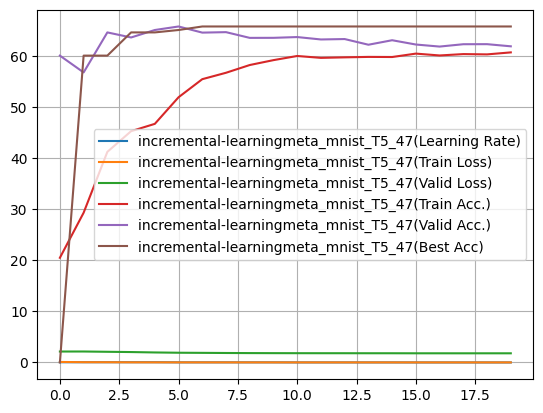

In [19]:
for ses in range(start_sess, args.num_task):
    args.sess=ses 
        
    if(ses==0):
        torch.save(model.state_dict(), os.path.join(args.savepoint, 'base_model.pth.tar'))
        args.epochs = 5
    if(ses==4):
        args.lr = 0.05
    if(start_sess==ses and start_sess!=0): 
        inc_dataset._current_task = ses
        with open(args.savepoint + "/sample_per_task_testing_"+str(args.sess-1)+".pickle", 'rb') as handle:
            sample_per_task_testing = pickle.load(handle)
        inc_dataset.sample_per_task_testing = sample_per_task_testing
        args.sample_per_task_testing = sample_per_task_testing
        
    if ses>0: 
        args.epochs = 20
        path_model=os.path.join(args.savepoint, 'session_'+str(ses-1) + '_model_best.pth.tar')  
        prev_best=torch.load(path_model)
        model.load_state_dict(prev_best)

        with open(args.savepoint + "/memory_"+str(args.sess-1)+".pickle", 'rb') as handle:
            memory = pickle.load(handle)
            
            
            
    task_info, train_loader, val_loader, test_loader, for_memory = inc_dataset.new_task(memory)
    print(task_info)
    print(inc_dataset.sample_per_task_testing)
    args.sample_per_task_testing = inc_dataset.sample_per_task_testing
        
        
    main_learner=Learner(model=model,args=args,trainloader=train_loader,
                            testloader=test_loader, use_cuda=use_cuda)
        
        
    main_learner.learn()
    memory = inc_dataset.get_memory(memory, for_memory)

    acc_task = main_learner.meta_test(main_learner.best_model, memory, inc_dataset)
        
        
    with open(args.savepoint + "/memory_"+str(args.sess)+".pickle", 'wb') as handle:
        pickle.dump(memory, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(args.savepoint + "/acc_task_"+str(args.sess)+".pickle", 'wb') as handle:
        pickle.dump(acc_task, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
    with open(args.savepoint + "/sample_per_task_testing_"+str(args.sess)+".pickle", 'wb') as handle:
        pickle.dump(inc_dataset.sample_per_task_testing, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    time.sleep(5)